In [22]:
# Main
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Modelling
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from fbprophet import Prophet
pd.plotting.register_matplotlib_converters()

In [107]:
def flatten(x):
    return [z for y in x for z in y ]

In [24]:
def plot_grid(df, n_cols, figsize):
    n_rows = int(np.ceil(len(df.columns)/n_cols))
    df.plot(subplots=True, layout=(n_rows, n_cols), figsize=figsize)

In [23]:
def plot_fcst(fcst, train=None, test=None):
    fcst = fcst.set_index("ds")
    ax = fcst.yhat.plot()
    lower = fcst.yhat_lower
    upper = fcst.yhat_upper
    plt.fill_between(fcst.index, y1=lower, y2=upper, alpha=0.3)
    if train is not None:
        train.plot(style="k.")
    if test is not None:
        test.plot(style="r.")

In [ ]:
def plot_grid_fcst(products):
    n_rows = int(np.ceil(len(df.columns)/n_cols))

In [25]:
plt.rcParams["figure.figsize"] = (14,4)

In [44]:
data = pd.read_csv("../data/base_limpia.csv", parse_dates=["tiempo", "fecha pedido", "fecha liq"])

In [45]:
data.head()

,tiempo,nro factura,cliente,categoria,tipo negocio,localidad,direccion,plaza/campaña,producto,nro pedido,...,u pedidas,kg pedidos,fecha liq,u entregadas,kg entregados,importe bruto,importe factura,sucursal,longitud,latitud
0,2017-05-29,93315173,200008870.0,a5,mayorista,santa fe,av del valle 7199,plaza,90746,2736812,...,1,1.250,2017-05-29,1,1.250,231.70,12421.88,santa fe,-60.691979,-31.602638
1,2017-06-14,93368453,200008870.0,a5,mayorista,santa fe,av del valle 7199,plaza,90746,2765668,...,1,1.250,2017-06-14,1,1.250,231.70,19944.84,santa fe,-60.691979,-31.602638
2,2017-02-21,93074208,200008889.0,a3,supermercado,santa fe,gral.paz 5374,plaza,90740,2546672,...,2,1.464,2017-02-21,2,1.464,324.96,24534.07,santa fe,-60.686356,-31.620964
3,2017-05-11,93270490,200008889.0,a3,supermercado,santa fe,gral.paz 5374,plaza,90746,2702464,...,1,1.250,2017-05-11,1,1.250,231.70,27204.63,santa fe,-60.686356,-31.620964
4,2017-05-24,93309184,200008889.0,a3,supermercado,santa fe,gral.paz 5374,plaza,90746,2732609,...,1,1.250,2017-05-24,1,1.250,231.70,16573.12,santa fe,-60.686356,-31.620964


In [46]:
u_producto = pd.pivot_table(data, values="u pedidas", index="tiempo", columns="producto", aggfunc="sum").asfreq("D")

In [47]:
u_producto.head()

producto,16034,16061,16062,16070,16071,16075,16076,16077,16080,16081,...,44151,44152,44154,44155,44157,44158,90739,90740,90745,90746
tiempo,,,,,,,,,,,,,,,,,,,,,
2017-01-02,NaN,7.0,1.0,25.0,11.0,3.0,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,1.0,NaN,NaN,4.0,1.0,NaN,NaN
2017-01-03,NaN,21.0,NaN,27.0,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0,NaN,NaN
2017-01-04,NaN,NaN,NaN,8.0,4.0,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN
2017-01-05,NaN,3.0,NaN,6.0,3.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,10.0,NaN,1.0,NaN,1.0,NaN,NaN
2017-01-06,NaN,NaN,2.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


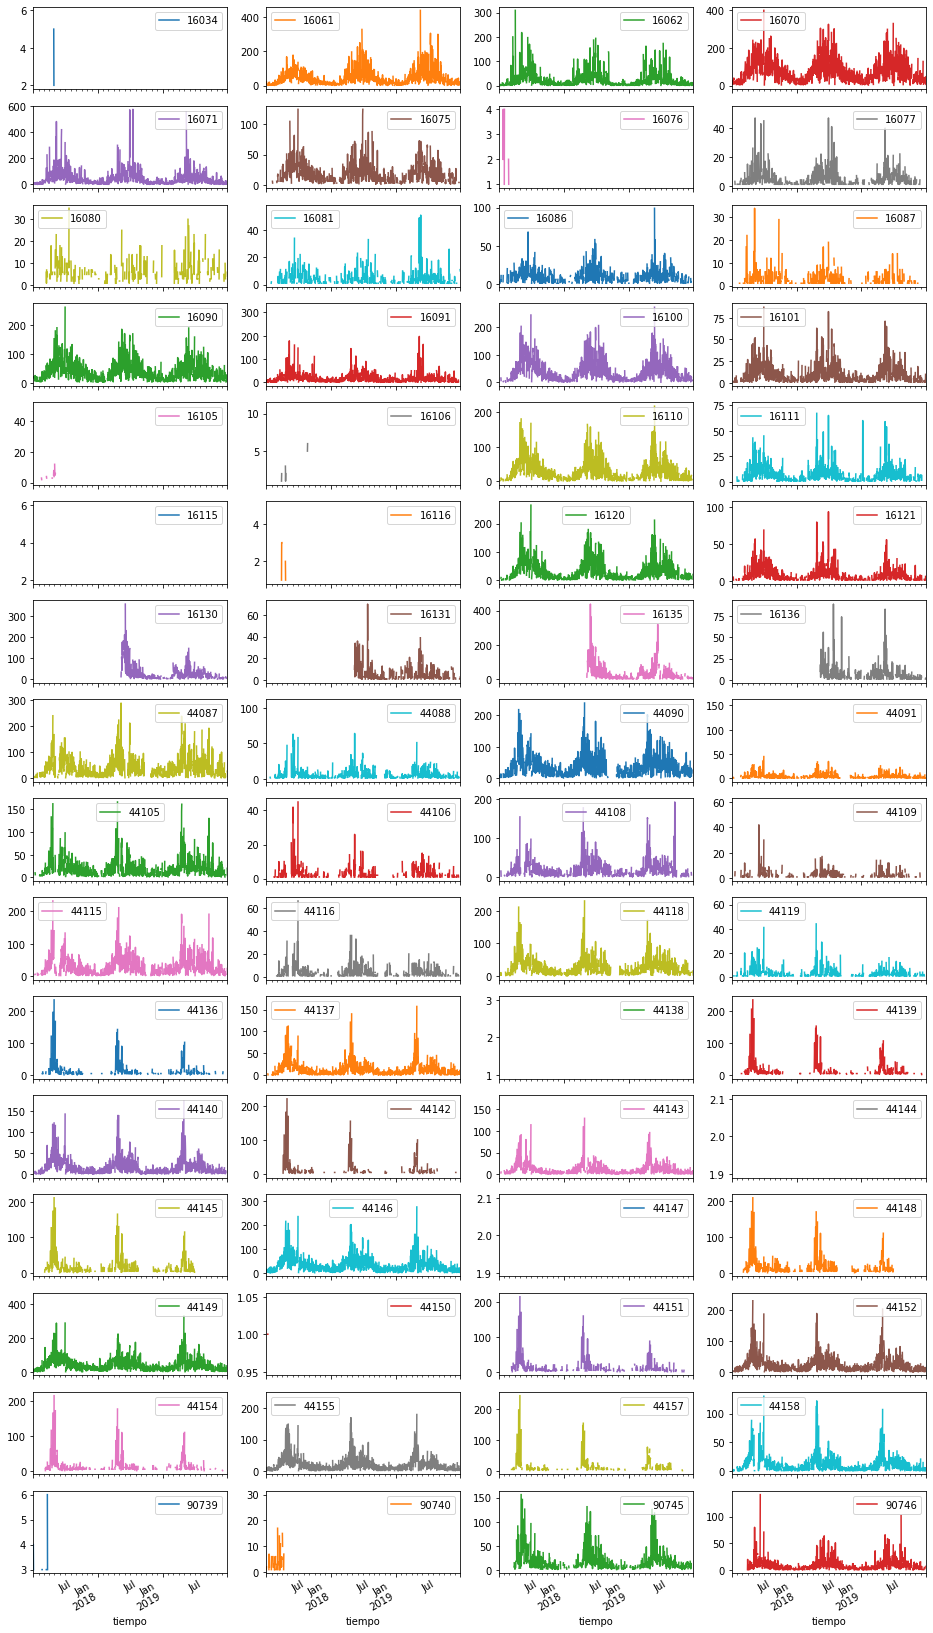

In [48]:
plot_grid(u_producto, n_cols=4, figsize=(16,32))

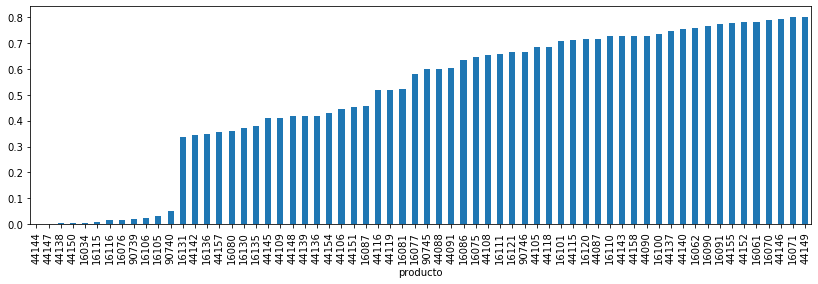

In [49]:
amount_info = (u_producto.notna()).sum() / len(u_producto)
amount_info.sort_values().plot(kind="bar")

In [50]:
T = 0.5
forecastable = (amount_info > T)
u_producto_forecastable = u_producto.loc[:, forecastable]

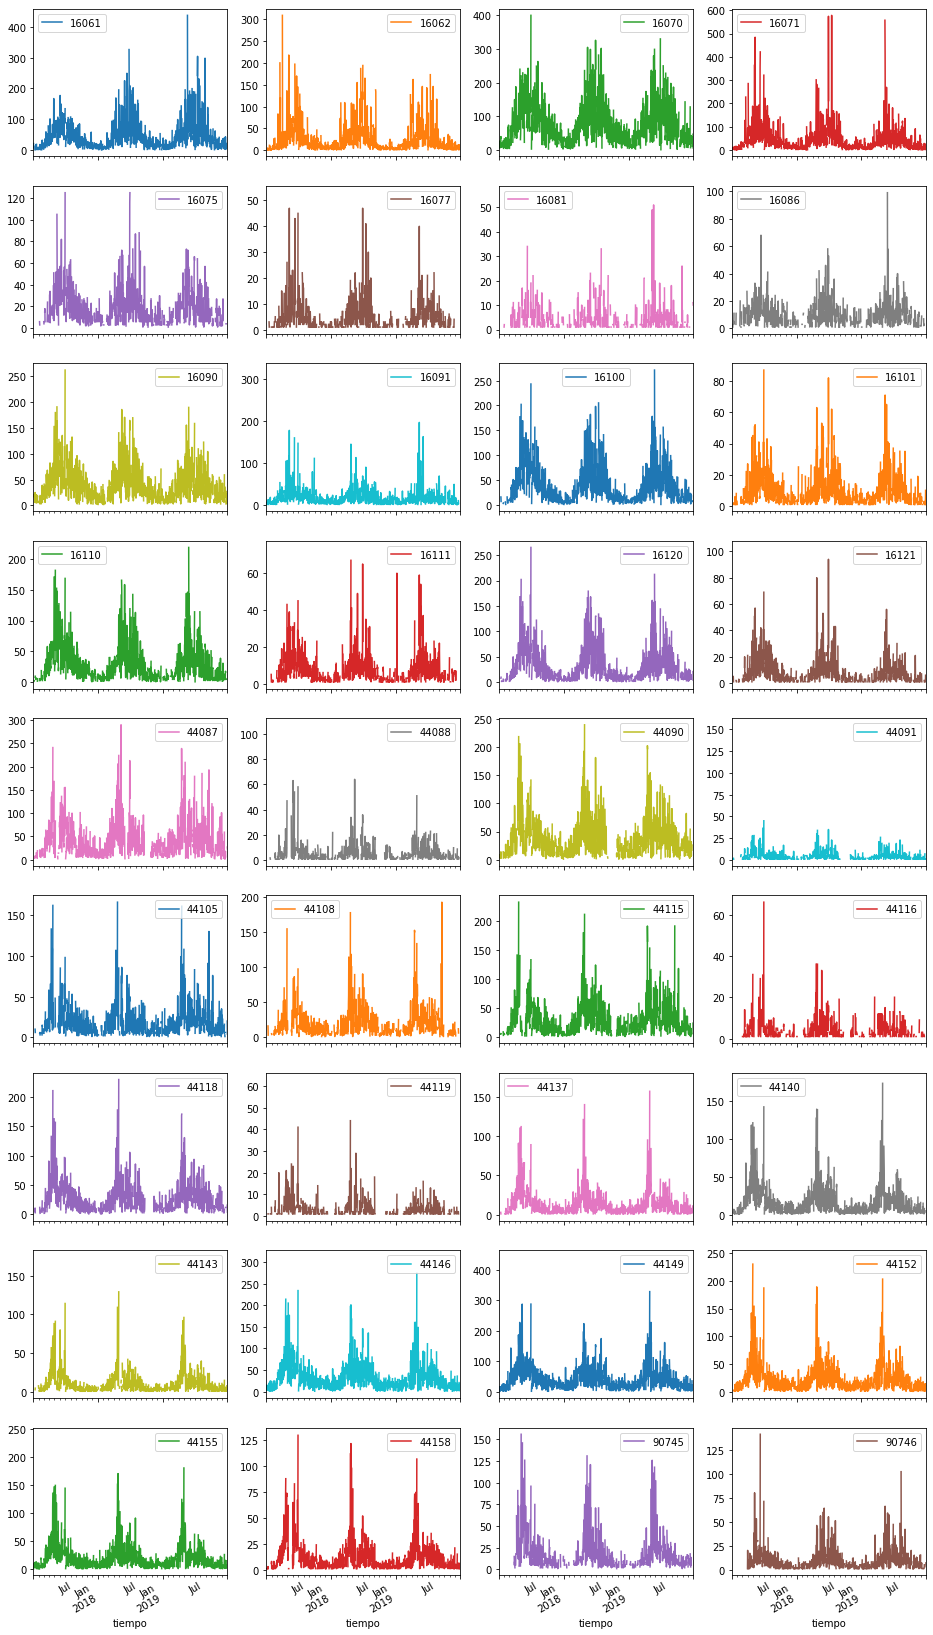

In [51]:
plot_grid(u_producto_forecastable, n_cols=4, figsize=(16, 32))

In [65]:
train, test = u_producto_forecastable[:"2018-12-31"], u_producto_forecastable["2019-01-01":]

In [156]:
class Forecast:
    def __init__(self, use_boxcox=True):
        self.models = dict()
        self.fcst = dict()
        self.lmbda_boxcox = dict()
        self.use_boxcox = use_boxcox
    
    def fit(self, train_df):
        for product in train_df.columns:
            self.models[product] = Prophet(
                seasonality_mode="additive", 
                yearly_seasonality=10, 
                weekly_seasonality=False, 
                daily_seasonality=False, 
                interval_width=0.8, 
                mcmc_samples=0)
            target = train_df[product]
            target.index.name = "ds"
            target.name = "y"
            target = target.dropna()
            target_boxcox, self.lmbda_boxcox[product] = boxcox(target)
            target_boxcox = pd.Series(target_boxcox, index=target.index, name="y")
            self.models[product].fit(target_boxcox.reset_index())
        return self.models
            
    def predict(self, steps=7, freq="D"):
        for product, model in self.models.items():
            future = model.make_future_dataframe(steps, freq=freq)
            fcst_boxcox = model.predict(future).set_index("ds")
            self.fcst[product] = fcst_boxcox.copy()
            self.fcst[product][["yhat", "yhat_lower", "yhat_upper"]] =\
            inv_boxcox(self.fcst[product][["yhat", "yhat_lower", "yhat_upper"]], self.lmbda_boxcox[product])
        return pd.concat(self.fcst, axis=1)

In [159]:
model = Forecast()
model.fit(train)
fcst = model.predict(steps=365).asfreq("D")

In [160]:
fcst = fcst.asfreq("D")

In [169]:
fcst.columns

MultiIndex([(16061,                      'trend'),
            (16061,                 'yhat_lower'),
            (16061,                 'yhat_upper'),
            (16061,                'trend_lower'),
            (16061,                'trend_upper'),
            (16061,             'additive_terms'),
            (16061,       'additive_terms_lower'),
            (16061,       'additive_terms_upper'),
            (16061,                     'yearly'),
            (16061,               'yearly_lower'),
            ...
            (90746,             'additive_terms'),
            (90746,       'additive_terms_lower'),
            (90746,       'additive_terms_upper'),
            (90746,                     'yearly'),
            (90746,               'yearly_lower'),
            (90746,               'yearly_upper'),
            (90746,       'multiplicative_terms'),
            (90746, 'multiplicative_terms_lower'),
            (90746, 'multiplicative_terms_upper'),
            (90

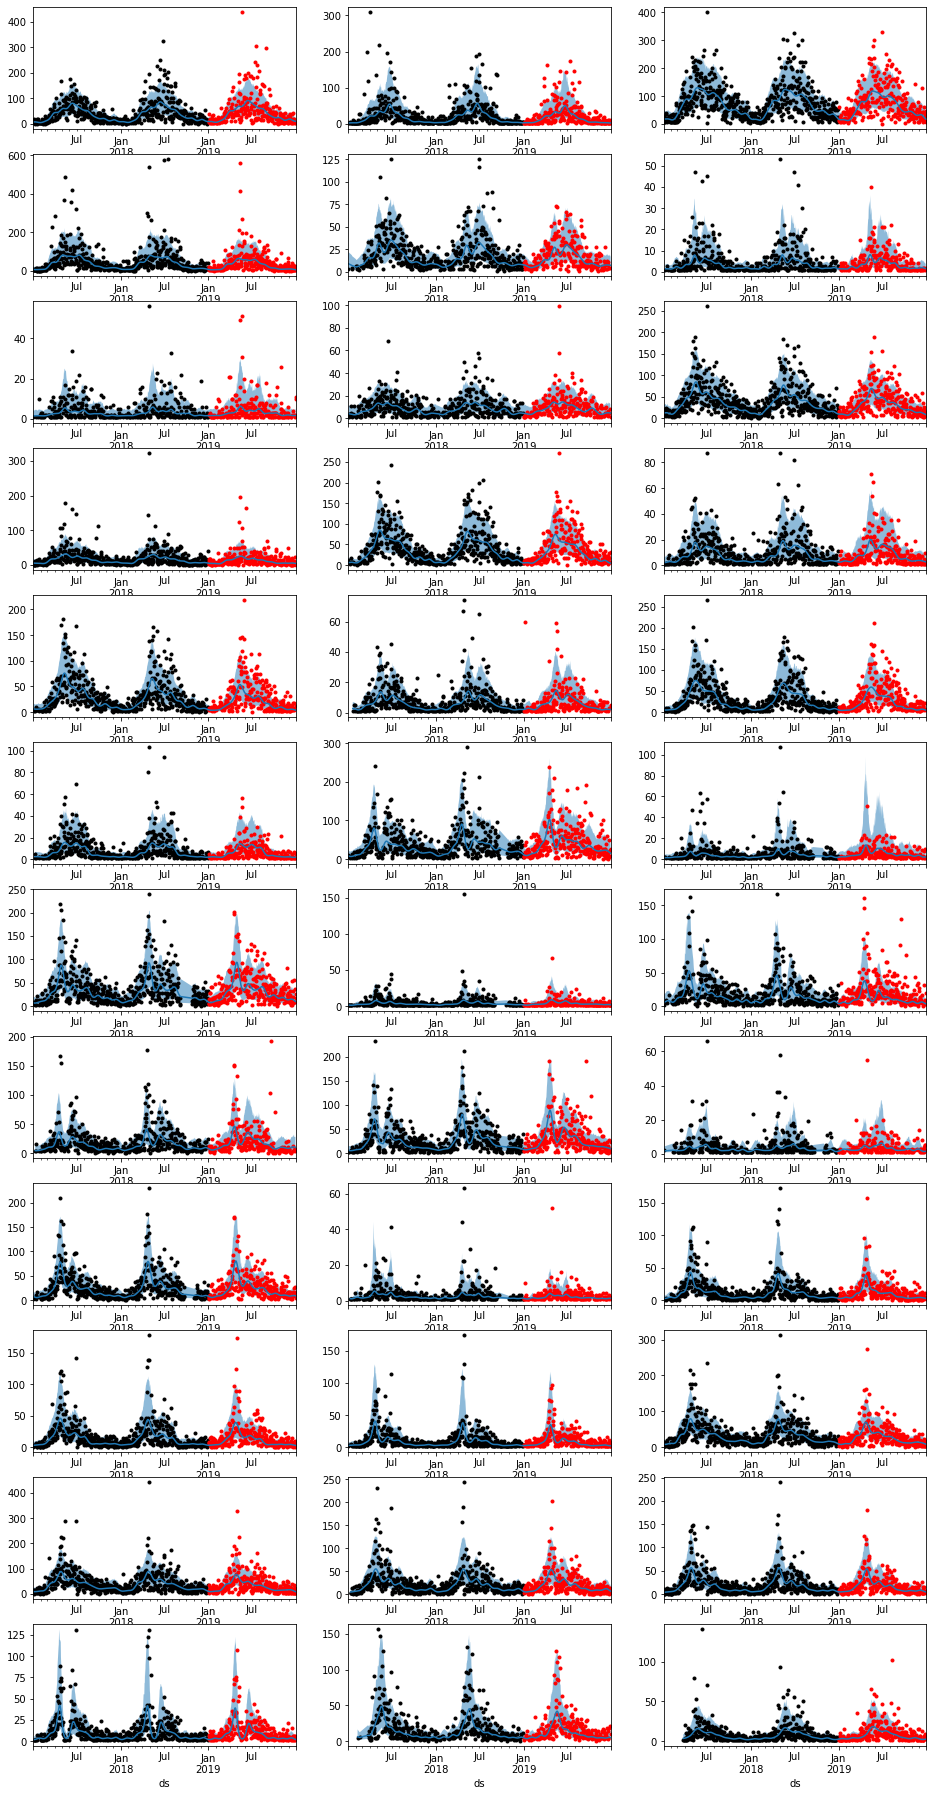

In [118]:
f, axs = plt.subplots(12, 3, figsize=(16,32))
prod_ax = zip(model.fcst.keys(), flatten(axs))
for product, ax in prod_ax:
    train[product].plot(style="k.", ax=ax)
    test[product].plot(style="r.", ax=ax)
    fcst = model.fcst[product]
    fcst = fcst.set_index("ds")
    fcst.yhat.plot(ax=ax)
    lower = fcst.yhat_lower
    upper = fcst.yhat_upper
    ax.fill_between(fcst.index, y1=lower, y2=upper, alpha=0.5)

In [119]:
model.fcst.keys()

dict_keys([16061, 16062, 16070, 16071, 16075, 16077, 16081, 16086, 16090, 16091, 16100, 16101, 16110, 16111, 16120, 16121, 44087, 44088, 44090, 44091, 44105, 44108, 44115, 44116, 44118, 44119, 44137, 44140, 44143, 44146, 44149, 44152, 44155, 44158, 90745, 90746])

In [139]:
fcst = model.fcst.copy()

In [142]:
for key in fcst.keys():
    fcst[key] = fcst[key].set_index("ds")

In [143]:
df = pd.concat(fcst, axis=1,)

In [146]:
df = df.asfreq("D")

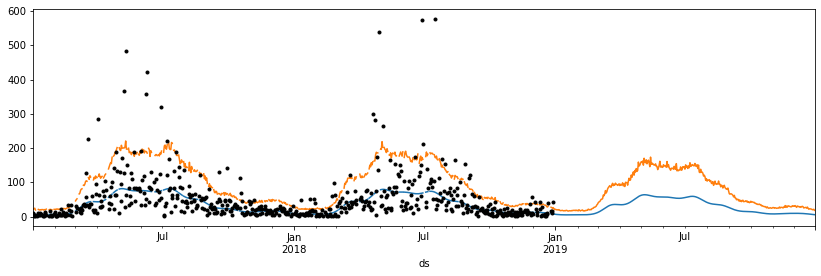

In [155]:
df[16071].yhat.plot()
df[16071].yhat_upper.plot()
train[16071].plot(style="k.")

In [135]:
model.fcst[16061]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-02,4.663919,2.177808,22.007813,4.663919,4.663919,-2.151085,-2.151085,-2.151085,-2.151085,-2.151085,-2.151085,0.0,0.0,0.0,7.607071
1,2017-01-03,4.664366,2.029742,19.850390,4.664366,4.664366,-2.142048,-2.142048,-2.142048,-2.142048,-2.142048,-2.142048,0.0,0.0,0.0,7.654909
2,2017-01-05,4.665262,2.238458,22.339628,4.665262,4.665262,-2.123822,-2.123822,-2.123822,-2.123822,-2.123822,-2.123822,0.0,0.0,0.0,7.752082
3,2017-01-07,4.666158,2.209583,22.159009,4.666158,4.666158,-2.111741,-2.111741,-2.111741,-2.111741,-2.111741,-2.111741,0.0,0.0,0.0,7.818587
4,2017-01-11,4.667950,2.267799,20.518928,4.667950,4.667950,-2.130811,-2.130811,-2.130811,-2.130811,-2.130811,-2.130811,0.0,0.0,0.0,7.730144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
930,2019-12-25,5.128289,3.466161,28.188464,5.126869,5.129902,-2.078729,-2.078729,-2.078729,-2.078729,-2.078729,-2.078729,0.0,0.0,0.0,10.716725
931,2019-12-26,5.128707,3.334084,26.272937,5.127275,5.130325,-2.108278,-2.108278,-2.108278,-2.108278,-2.108278,-2.108278,0.0,0.0,0.0,10.525543
932,2019-12-27,5.129124,3.109117,27.327679,5.127681,5.130749,-2.131402,-2.131402,-2.131402,-2.131402,-2.131402,-2.131402,0.0,0.0,0.0,10.378421
933,2019-12-28,5.129542,3.259390,25.865219,5.128094,5.131173,-2.148294,-2.148294,-2.148294,-2.148294,-2.148294,-2.148294,0.0,0.0,0.0,10.272711
